## model-1
  


**Decision Tree Models to predict if a crash has_injuries**


Create Models to predict if a crash has_injuries:  
- 0: NO INJURY
- 1: HAS INJURY  

Steps per Model:
- Create 2019 Model using Training and Validation split
    - Use Grid Search to find best hyperparameters
    - Grid Search will use 2019 Training set for CrossValidation
- Using 2019 Fitted Model
    - Test 2019 Model on 2019 test data with best hyperparameters
    - Test 2019 Model on 2020 data with best hyperparameters
- Handling Class Imbalance
    - Each model is tested using class_weight='balanced'
    - Then Each model is tested using a resampled dataset

Report for each model run:  
- Best Hyperparameters
- Model scores

In [1]:
!pip install klib

In [2]:
!pip install sweetviz

   ---------------------------------------- 0.0/15.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.1 MB 660.6 kB/s eta 0:00:23
   ---------------------------------------- 0.1/15.1 MB 1.2 MB/s eta 0:00:13
   - -------------------------------------- 0.6/15.1 MB 5.1 MB/s eta 0:00:03
   ----- ---------------------------------- 2.2/15.1 MB 12.5 MB/s eta 0:00:02
   ------------ --------------------------- 4.6/15.1 MB 20.9 MB/s eta 0:00:01
   --------------------- ------------------ 8.0/15.1 MB 30.1 MB/s eta 0:00:01
   ------------------------------ --------- 11.4/15.1 MB 59.5 MB/s eta 0:00:01
   ---------------------------------- ----- 13.2/15.1 MB 65.6 MB/s eta 0:00:01
   ---------------------------------------  15.1/15.1 MB 72.6 MB/s eta 0:00:01
   ---------------------------------------- 15.1/15.1 MB 59.5 MB/s eta 0:00:00


In [4]:
!pip install graphviz

   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   ---------------------------------- ----- 41.0/47.1 kB 487.6 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 466.9 kB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import klib
import sweetviz
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer

from imblearn.over_sampling import *
from imblearn.under_sampling import *

from sklearn.utils import *
from sklearn.model_selection import train_test_split
from platform import python_version

from sklearn.tree import export_graphviz
import graphviz



pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120
pd.options.display.float_format='{:,.2f}'.format
pd.options.display.precision = 2

np.set_printoptions(precision=2, linewidth=120, suppress=True, edgeitems=5)

sns.set_style("white")

StartBold = "\033[1m"
EndBold = "\033[0m"

print('python',python_version())
print(np.__name__, np.__version__)
print(pd.__name__, pd.__version__)
print(klib.__name__, klib.__version__)
#print(pp.__name__, pp.__version__)
print(sklearn.__name__, sklearn.__version__)
print(sweetviz.__name__, sweetviz.__version__)

python 3.11.7
numpy 1.26.4
pandas 2.1.4
klib 1.1.2
sklearn 1.2.2
sweetviz 2.3.1


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn import metrics

In [7]:
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
#%config InlineBackend.figure_formats = ['png', 'retina', 'jpeg', 'svg', 'pdf']

In [8]:
# Global Parameters

random_state = 2021
n_jobs = 4

# Define Dictionary Mappers

In [9]:
week_days = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
is_weekday = {0:'Weekend',1:'Weekday'}

# Read Data

In [11]:
file_crash_df = r'C:\Users\Srikanth\Downloads\crash_df.csv'

crash_df = pd.read_csv(file_crash_df)

crash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814109 entries, 0 to 814108
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               814109 non-null  int64  
 1   crash_date               814109 non-null  object 
 2   crash_year               814109 non-null  int64  
 3   crash_month              814109 non-null  int64  
 4   crash_day_of_week        814109 non-null  int64  
 5   crash_hour               814109 non-null  int64  
 6   crash_time_of_day        814109 non-null  object 
 7   latitude                 814109 non-null  float64
 8   longitude                814109 non-null  float64
 9   beat_of_occurrence       814109 non-null  int64  
 10  address                  814109 non-null  object 
 11  street_no                814109 non-null  int64  
 12  street_direction         814108 non-null  object 
 13  street_name              814109 non-null  object 
 14  post

# Engineer New Features

In [12]:
crash_df['is_weekday'] = crash_df.crash_day_of_week.map(lambda x: 0 if x in [1,7] else 1)


# Select Features of interest

In [13]:
features_names = [
#    'crash_date',
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
#    'crash_hour',
    'crash_time_of_day', # New
    'is_weekday', #New
    'latitude',
    'longitude',
#    'beat_of_occurrence', # Should be considered as categorical, don't scale.
#    'address',
#    'street_no',
#    'street_direction',
#    'street_name',
    'posted_speed_limit',
    'traffic_control_device',
    'device_condition',
    'weather_condition',
    'lighting_condition',
    'trafficway_type',
    'alignment',
    'roadway_surface_cond',
    'road_defect',
    'first_crash_type',
    'prim_contributory_cause',
    'sec_contributory_cause',
    'num_units',
#    'intersection_related_i',
#    'not_right_of_way_i',
#    'hit_and_run_i',
]

target_names = [
    'has_injuries',  # New
#    'has_fatal',  # New
#    'crash_type',
#    'damage',
#    'injuries_total',
#    'injuries_fatal',
#    'injuries_incapacitating',
#    'inj_non_incap',
#    'inj_report_not_evdnt',
#    'injuries_no_indication',
#    'most_severe_injury',
]

all_columns = features_names + target_names
all_columns

['crash_year',
 'crash_month',
 'crash_time_of_day',
 'is_weekday',
 'latitude',
 'longitude',
 'posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'trafficway_type',
 'alignment',
 'roadway_surface_cond',
 'road_defect',
 'first_crash_type',
 'prim_contributory_cause',
 'sec_contributory_cause',
 'num_units',
 'has_injuries']

# Filter for only 2019

In [14]:


# Filter the dataframe for years between 2015 and 2024
filtered_crash_df = crash_df[(crash_df.crash_year >= 2015) & (crash_df.crash_year <= 2024)]

# Select the columns as specified in all_columns, starting from the second element
filtered_crash_df = filtered_crash_df[all_columns[1:]]
filtered_crash_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814101 entries, 0 to 814108
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   crash_month              814101 non-null  int64  
 1   crash_time_of_day        814101 non-null  object 
 2   is_weekday               814101 non-null  int64  
 3   latitude                 814101 non-null  float64
 4   longitude                814101 non-null  float64
 5   posted_speed_limit       814101 non-null  int64  
 6   traffic_control_device   814101 non-null  object 
 7   device_condition         814101 non-null  object 
 8   weather_condition        814101 non-null  object 
 9   lighting_condition       814101 non-null  object 
 10  trafficway_type          814101 non-null  object 
 11  alignment                814101 non-null  object 
 12  roadway_surface_cond     814101 non-null  object 
 13  road_defect              814101 non-null  object 
 14  first_cra

In [15]:
crash_2019_df = filtered_crash_df

# Determine features / target

In [16]:
features = crash_2019_df[features_names[1:]].copy() # skip year column
target = crash_2019_df[target_names].has_injuries.copy()

features.shape, target.shape

((814101, 18), (814101,))

# Encode Categorical

In [17]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814101 entries, 0 to 814108
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   crash_month              814101 non-null  int64  
 1   crash_time_of_day        814101 non-null  object 
 2   is_weekday               814101 non-null  int64  
 3   latitude                 814101 non-null  float64
 4   longitude                814101 non-null  float64
 5   posted_speed_limit       814101 non-null  int64  
 6   traffic_control_device   814101 non-null  object 
 7   device_condition         814101 non-null  object 
 8   weather_condition        814101 non-null  object 
 9   lighting_condition       814101 non-null  object 
 10  trafficway_type          814101 non-null  object 
 11  alignment                814101 non-null  object 
 12  roadway_surface_cond     814101 non-null  object 
 13  road_defect              814101 non-null  object 
 14  first_cra

In [18]:
features.select_dtypes('object').columns.values

array(['crash_time_of_day', 'traffic_control_device', 'device_condition', 'weather_condition', 'lighting_condition',
       'trafficway_type', 'alignment', 'roadway_surface_cond', 'road_defect', 'first_crash_type',
       'prim_contributory_cause', 'sec_contributory_cause'], dtype=object)

In [19]:
features['crash_month'] = features['crash_month'].astype('object')

In [20]:
features_dm = pd.get_dummies(features)

In [21]:
# Split data in to Features X and Target y
X = features_dm
y = target
print('X and y shapes:')
print(X.shape,y.shape,'\n')
print('Target Ratio:')
print(y.value_counts(normalize=True, dropna=False),'\n')

X and y shapes:
(814101, 204) (814101,) 

Target Ratio:
has_injuries
0   0.86
1   0.14
Name: proportion, dtype: float64 



In [22]:
X

,is_weekday,latitude,longitude,posted_speed_limit,num_units,crash_month_1,crash_month_2,crash_month_3,crash_month_4,crash_month_5,crash_month_6,crash_month_7,crash_month_8,crash_month_9,crash_month_10,crash_month_11,crash_month_12,crash_time_of_day_evening,crash_time_of_day_mid_day,crash_time_of_day_morning,crash_time_of_day_overnight,traffic_control_device_BICYCLE CROSSING SIGN,traffic_control_device_DELINEATORS,traffic_control_device_FLASHING CONTROL SIGNAL,traffic_control_device_LANE USE MARKING,traffic_control_device_NO CONTROLS,traffic_control_device_NO PASSING,traffic_control_device_OTHER,traffic_control_device_OTHER RAILROAD CROSSING,traffic_control_device_OTHER REG. SIGN,traffic_control_device_OTHER WARNING SIGN,traffic_control_device_PEDESTRIAN CROSSING SIGN,traffic_control_device_POLICE/FLAGMAN,traffic_control_device_RAILROAD CROSSING GATE,traffic_control_device_RR CROSSING SIGN,traffic_control_device_SCHOOL ZONE,traffic_control_device_STOP SIGN/FLASHER,traffic_control_device_TRAFFIC SIGNAL,traffic_control_device_UNKNOWN,traffic_control_device_YIELD,device_condition_FUNCTIONING IMPROPERLY,device_condition_FUNCTIONING PROPERLY,device_condition_MISSING,device_condition_NO CONTROLS,device_condition_NOT FUNCTIONING,device_condition_OTHER,device_condition_UNKNOWN,device_condition_WORN REFLECTIVE MATERIAL,"weather_condition_BLOWING SAND, SOIL, DIRT",weather_condition_BLOWING SNOW,...,prim_contributory_cause_PHYSICAL CONDITION OF DRIVER,prim_contributory_cause_RELATED TO BUS STOP,prim_contributory_cause_ROAD CONSTRUCTION/MAINTENANCE,prim_contributory_cause_ROAD ENGINEERING/SURFACE/MARKING DEFECTS,prim_contributory_cause_TEXTING,prim_contributory_cause_TURNING RIGHT ON RED,prim_contributory_cause_UNABLE TO DETERMINE,prim_contributory_cause_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"prim_contributory_cause_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",prim_contributory_cause_WEATHER,sec_contributory_cause_ANIMAL,sec_contributory_cause_BICYCLE ADVANCING LEGALLY ON RED LIGHT,sec_contributory_cause_CELL PHONE USE OTHER THAN TEXTING,sec_contributory_cause_DISREGARDING OTHER TRAFFIC SIGNS,sec_contributory_cause_DISREGARDING ROAD MARKINGS,sec_contributory_cause_DISREGARDING STOP SIGN,sec_contributory_cause_DISREGARDING TRAFFIC SIGNALS,sec_contributory_cause_DISREGARDING YIELD SIGN,sec_contributory_cause_DISTRACTION - FROM INSIDE VEHICLE,sec_contributory_cause_DISTRACTION - FROM OUTSIDE VEHICLE,"sec_contributory_cause_DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)",sec_contributory_cause_DRIVING ON WRONG SIDE/WRONG WAY,sec_contributory_cause_DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,sec_contributory_cause_EQUIPMENT - VEHICLE CONDITION,"sec_contributory_cause_EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST",sec_contributory_cause_EXCEEDING AUTHORIZED SPEED LIMIT,sec_contributory_cause_EXCEEDING SAFE SPEED FOR CONDITIONS,sec_contributory_cause_FAILING TO REDUCE SPEED TO AVOID CRASH,sec_contributory_cause_FAILING TO YIELD RIGHT-OF-WAY,sec_contributory_cause_FOLLOWING TOO CLOSELY,sec_contributory_cause_HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE),sec_contributory_cause_IMPROPER BACKING,sec_contributory_cause_IMPROPER LANE USAGE,sec_contributory_cause_IMPROPER OVERTAKING/PASSING,sec_contributory_cause_IMPROPER TURNING/NO SIGNAL,sec_contributory_cause_MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT,sec_contributory_cause_NOT APPLICABLE,sec_contributory_cause_OBSTRUCTED CROSSWALKS,"sec_contributory_cause_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER",sec_contributory_cause_PASSING STOPPED SCHOOL BUS,sec_contributory_cause_PHYSICAL CONDITION OF DRIVER,sec_contributory_cause_RELATED TO BUS STOP,sec_contributory_cause_ROAD CONSTRUCTION/MAINTENANCE,sec_contributory_cause_ROAD ENGINEERING/SURFACE/MARKING DEFECTS,sec_contributory_cause_TEXTING,sec_contributory_cause_TURNING RIGHT ON RED,sec_contributory_cause_UNABLE TO DETERMINE,sec_contributory_cause_UNDER

# Create Train/Test datasets

In [23]:
# Split data into Train and Test
# We stratify to make sure target representation is kept in the new datasets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
#                                                    stratify=y,
                                                    random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((651280, 204), (162821, 204), (651280,), (162821,))

In [24]:
print('Training Data:')
print('--------------')
print('X and y shapes:')
print(X_train.shape,y_train.shape,'\n')
print('Target Ratio:')
print(y_train.value_counts(normalize=True, dropna=False),'\n')

Training Data:
--------------
X and y shapes:
(651280, 204) (651280,) 

Target Ratio:
has_injuries
0   0.86
1   0.14
Name: proportion, dtype: float64 



In [25]:
print('Testing Data:')
print('-------------')
print('X and y shapes:')
print(X_test.shape,y_test.shape,'\n')
print('Target Ratio:')
print(y_test.value_counts(normalize=True, dropna=False),'\n')

Testing Data:
-------------
X and y shapes:
(162821, 204) (162821,) 

Target Ratio:
has_injuries
0   0.86
1   0.14
Name: proportion, dtype: float64 



It's visible that we have an imbalanced target that we need to consider during our evaluations.

# Resampling

Resampling to compensate the target class that has low representation.

In [26]:
ros = RandomOverSampler(random_state=random_state)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print('Testing Data:')
print('-------------')
print('X and y shapes:')
print(X_train_resampled.shape,y_train_resampled.shape,'\n')
print('Target Ratio:')
print(y_train_resampled.value_counts(normalize=True, dropna=False),'\n')

Testing Data:
-------------
X and y shapes:
(1122780, 204) (1122780,) 

Target Ratio:
has_injuries
0   0.50
1   0.50
Name: proportion, dtype: float64 



In [27]:
X_train

,is_weekday,latitude,longitude,posted_speed_limit,num_units,crash_month_1,crash_month_2,crash_month_3,crash_month_4,crash_month_5,crash_month_6,crash_month_7,crash_month_8,crash_month_9,crash_month_10,crash_month_11,crash_month_12,crash_time_of_day_evening,crash_time_of_day_mid_day,crash_time_of_day_morning,crash_time_of_day_overnight,traffic_control_device_BICYCLE CROSSING SIGN,traffic_control_device_DELINEATORS,traffic_control_device_FLASHING CONTROL SIGNAL,traffic_control_device_LANE USE MARKING,traffic_control_device_NO CONTROLS,traffic_control_device_NO PASSING,traffic_control_device_OTHER,traffic_control_device_OTHER RAILROAD CROSSING,traffic_control_device_OTHER REG. SIGN,traffic_control_device_OTHER WARNING SIGN,traffic_control_device_PEDESTRIAN CROSSING SIGN,traffic_control_device_POLICE/FLAGMAN,traffic_control_device_RAILROAD CROSSING GATE,traffic_control_device_RR CROSSING SIGN,traffic_control_device_SCHOOL ZONE,traffic_control_device_STOP SIGN/FLASHER,traffic_control_device_TRAFFIC SIGNAL,traffic_control_device_UNKNOWN,traffic_control_device_YIELD,device_condition_FUNCTIONING IMPROPERLY,device_condition_FUNCTIONING PROPERLY,device_condition_MISSING,device_condition_NO CONTROLS,device_condition_NOT FUNCTIONING,device_condition_OTHER,device_condition_UNKNOWN,device_condition_WORN REFLECTIVE MATERIAL,"weather_condition_BLOWING SAND, SOIL, DIRT",weather_condition_BLOWING SNOW,...,prim_contributory_cause_PHYSICAL CONDITION OF DRIVER,prim_contributory_cause_RELATED TO BUS STOP,prim_contributory_cause_ROAD CONSTRUCTION/MAINTENANCE,prim_contributory_cause_ROAD ENGINEERING/SURFACE/MARKING DEFECTS,prim_contributory_cause_TEXTING,prim_contributory_cause_TURNING RIGHT ON RED,prim_contributory_cause_UNABLE TO DETERMINE,prim_contributory_cause_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"prim_contributory_cause_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",prim_contributory_cause_WEATHER,sec_contributory_cause_ANIMAL,sec_contributory_cause_BICYCLE ADVANCING LEGALLY ON RED LIGHT,sec_contributory_cause_CELL PHONE USE OTHER THAN TEXTING,sec_contributory_cause_DISREGARDING OTHER TRAFFIC SIGNS,sec_contributory_cause_DISREGARDING ROAD MARKINGS,sec_contributory_cause_DISREGARDING STOP SIGN,sec_contributory_cause_DISREGARDING TRAFFIC SIGNALS,sec_contributory_cause_DISREGARDING YIELD SIGN,sec_contributory_cause_DISTRACTION - FROM INSIDE VEHICLE,sec_contributory_cause_DISTRACTION - FROM OUTSIDE VEHICLE,"sec_contributory_cause_DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)",sec_contributory_cause_DRIVING ON WRONG SIDE/WRONG WAY,sec_contributory_cause_DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,sec_contributory_cause_EQUIPMENT - VEHICLE CONDITION,"sec_contributory_cause_EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST",sec_contributory_cause_EXCEEDING AUTHORIZED SPEED LIMIT,sec_contributory_cause_EXCEEDING SAFE SPEED FOR CONDITIONS,sec_contributory_cause_FAILING TO REDUCE SPEED TO AVOID CRASH,sec_contributory_cause_FAILING TO YIELD RIGHT-OF-WAY,sec_contributory_cause_FOLLOWING TOO CLOSELY,sec_contributory_cause_HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE),sec_contributory_cause_IMPROPER BACKING,sec_contributory_cause_IMPROPER LANE USAGE,sec_contributory_cause_IMPROPER OVERTAKING/PASSING,sec_contributory_cause_IMPROPER TURNING/NO SIGNAL,sec_contributory_cause_MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT,sec_contributory_cause_NOT APPLICABLE,sec_contributory_cause_OBSTRUCTED CROSSWALKS,"sec_contributory_cause_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER",sec_contributory_cause_PASSING STOPPED SCHOOL BUS,sec_contributory_cause_PHYSICAL CONDITION OF DRIVER,sec_contributory_cause_RELATED TO BUS STOP,sec_contributory_cause_ROAD CONSTRUCTION/MAINTENANCE,sec_contributory_cause_ROAD ENGINEERING/SURFACE/MARKING DEFECTS,sec_contributory_cause_TEXTING,sec_contributory_cause_TURNING RIGHT ON RED,sec_contributory_cause_UNABLE TO DETERMINE,sec_contributory_cause_UNDER

# Scaling Data

I've considered whether to scale/normalize the dataset. I noticed that most of my features are categorical, which have been expanded into one-hot encoded dummy variables. For the other integer variables, I assume they can be used as they are since they represent ordinal values. However, I'll test normalization during my analysis.

**Note:** I've decided that scaling would make sense to apply to the `posted_speed_limit` and `num_units` variables.

In [28]:
X_train_Scaler = MinMaxScaler().fit(X_train)
X_train_mms = X_train_Scaler.transform(X_train) # mms = MinMaxScaled

X_train_resampled_Scaler = MinMaxScaler().fit(X_train_resampled)
X_train_resampled_mms = X_train_resampled_Scaler.transform(X_train_resampled)

X_test_mms = X_train_Scaler.transform(X_test)
X_test_rs_mms = X_train_resampled_Scaler.transform(X_test)

In [29]:
X_train_mms

array([[1.  , 0.77, 0.56, 0.3 , 0.06, ..., 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.31, 0.87, 0.  , 0.06, ..., 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.39, 0.35, 0.35, 0.06, ..., 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.37, 0.67, 0.3 , 0.06, ..., 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.7 , 0.69, 0.3 , 0.06, ..., 0.  , 1.  , 0.  , 0.  , 0.  ],
       ...,
       [1.  , 0.24, 0.78, 0.35, 0.06, ..., 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.81, 0.25, 0.25, 0.06, ..., 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.35, 0.33, 0.3 , 0.06, ..., 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.77, 0.71, 0.3 , 0.06, ..., 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.54, 0.63, 0.35, 0.06, ..., 0.  , 1.  , 0.  , 0.  , 0.  ]])

# Helper Functions

In [30]:
def get_GS_cv_results(gs):
    _cv_results_ = gs.cv_results_
    _scorer_keys = gs.scorer_.keys()

    df_gs_scores = pd.DataFrame()

    for k in _cv_results_.keys():
        if k.startswith('param_'):
            param_key = ('param',k.split('_',1)[1])
            param_values = _cv_results_[k]
            df_gs_scores = pd.concat([df_gs_scores,pd.DataFrame({param_key:param_values})], axis=1)

        elif k.startswith('mean_train') or k.startswith('mean_test'):
            score_key = (k.split('_',2)[2],k.split('_',2)[1])
            score_results = _cv_results_[k]
            df_gs_scores = pd.concat([df_gs_scores,pd.DataFrame({score_key:score_results})], axis=1)

    return df_gs_scores

def plot_grid_search_scores_grid(gs, display_plots=False):
    _cv_results_ = gs.cv_results_
    _scorer_keys = gs.scorer_.keys()
    _param_keys = list(_cv_results_['params'][0].keys())
    df_gs_scores = get_GS_cv_results(gs)

    display(df_gs_scores)

    if(display_plots):
        if len(_param_keys) > 1:
            for _score in _scorer_keys:
                dd = df_gs_scores[['param',_score]]
                dd.columns = dd.columns.droplevel(0)
                ddm = dd.melt(id_vars=_param_keys[:2],value_vars=['train','test'],var_name='dataset',value_name=_score)
                g = sns.FacetGrid(ddm,col=_param_keys[0],height=3)
                g.map_dataframe(sns.lineplot,_param_keys[1],_score,'dataset')
                g.add_legend()
        else:
            for _score in _scorer_keys:
                dd = df_gs_scores[['param',_score]]
                dd.columns = dd.columns.droplevel(0)
                ddm = dd.melt(id_vars=_param_keys,value_vars=['train','test'],var_name='dataset',value_name=_score)
                g = sns.FacetGrid(ddm, height=3)
                g.map_dataframe(sns.lineplot,_param_keys[0],_score,'dataset')
                g.add_legend()

def plot_grid_search_results(gs, plot_scoring='r2'):
    _cv_results_ = gs.cv_results_
    _scorer_keys = gs.scorer_.keys()

    print(f'{StartBold}Estimator:{EndBold}')
    print(gs.best_estimator_)
    print()
    print(f'{StartBold}Best Result (Suggested):{EndBold}')
    print(f'{StartBold}\t{"":20} {"train":>6} {"valdn":>6}{EndBold}')
    for _score in _scorer_keys:
        print('\t{2:>20} {0:>6.2f} {1:>6.2f}'.format(_cv_results_['mean_train_' + _score][gs.best_index_],
                                             _cv_results_['mean_test_' + _score][gs.best_index_],
                                             _score))
    print()
    print(f'{StartBold}Params:{EndBold}')
    print('\t{}'.format(gs.best_params_))
    print()


    scoring_label = plot_scoring
    not_negative = 1
    if plot_scoring.startswith('neg_'):
        scoring_label = plot_scoring[4:]
        not_negative = -1
    df = pd.DataFrame({
        'params': _cv_results_['params'],
        'mean_train_' + plot_scoring: _cv_results_['mean_train_' + plot_scoring] * not_negative,
        'mean_test_' + plot_scoring: _cv_results_['mean_test_' + plot_scoring] * not_negative
    })
    fig, ax = plt.subplots()
    df.plot('params',['mean_train_' + plot_scoring,'mean_test_' + plot_scoring], 'line', ax=ax)
    ax.axvline(gs.best_index_,0,1, color='r', linestyle='--')
    plt.grid(axis='both',c='lightgrey',ls=':')
    plt.xticks(ticks=range(df.params.count()), labels=df.params)
    plt.tick_params(axis='x', rotation=90)
    plt.ylabel(scoring_label)
    plt.legend(['train','valdn'])
    plt.show()

    if("beep" in globals()): beep(True)

def score_classification_model(fitted_model, X, y_true):
    p = fitted_model.predict(X)
    print('accuracy score:          {:>5.2f}'.format(metrics.accuracy_score(y_true,p)))
    print('f1 score:                {:>5.2f}'.format(metrics.f1_score(y_true,p)))
    print('recall score:            {:>5.2f}'.format(metrics.recall_score(y_true,p)))
    print('precision score:         {:>5.2f}'.format(metrics.precision_score(y_true,p)))
    print('balanced_accuracy score: {:>5.2f}'.format(metrics.balanced_accuracy_score(y_true,p)))
    print('roc_auc score:           {:>5.2f}'.format(metrics.roc_auc_score(y_true,p)))
    #print(metrics.classification_report(y_true,p))
    metrics.plot_confusion_matrix(fitted_model,X, y_true)
    plt.show()
    #print(metrics.classification_report(y_true,p, sample_weight=compute_sample_weight('balanced',y_true)))
    #metrics.plot_confusion_matrix(fitted_model,X, y_true, sample_weight=compute_sample_weight('balanced',y_true))

def plot_coefficients(coef, feature_names, top_n=0):
    _ = pd.DataFrame({'features':feature_names,'coef':coef}).sort_values('coef',key=lambda x: abs(x),ascending=False)
    if top_n > 0:
        _ = _.iloc[:top_n,:]
    #display(_)
    n_features = _.shape[0]
    #plt.subplots(figsize=(10,20))
    plt.barh(range(n_features), _['coef'], align='center')
    plt.yticks(np.arange(n_features), _['features'])
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.ylim(n_features,-1)
    plt.show()


# Models

## Common GridSearch Params

In [32]:
# Common Grid Search Parameters

grid_search_defaults = {
    'cv': 3,
    'scoring': ['f1', 'recall', 'precision', 'balanced_accuracy', 'accuracy', 'roc_auc'],
    'refit': 'f1',
    'return_train_score': True,
    'error_score': 0,
    'verbose': 3,
    'n_jobs': n_jobs,
}

## Decision Tree

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Estimator:
DecisionTreeClassifier(max_depth=128, min_samples_split=0.01, random_state=2021)

Best Result (Suggested):
	                      train  valdn
	                  f1   0.36   0.36
	              recall   0.24   0.24
	           precision   0.79   0.78
	   balanced_accuracy   0.61   0.61
	            accuracy   0.89   0.89
	             roc_auc   0.82   0.81

Params:
	{'max_depth': 128, 'min_samples_split': 0.01}



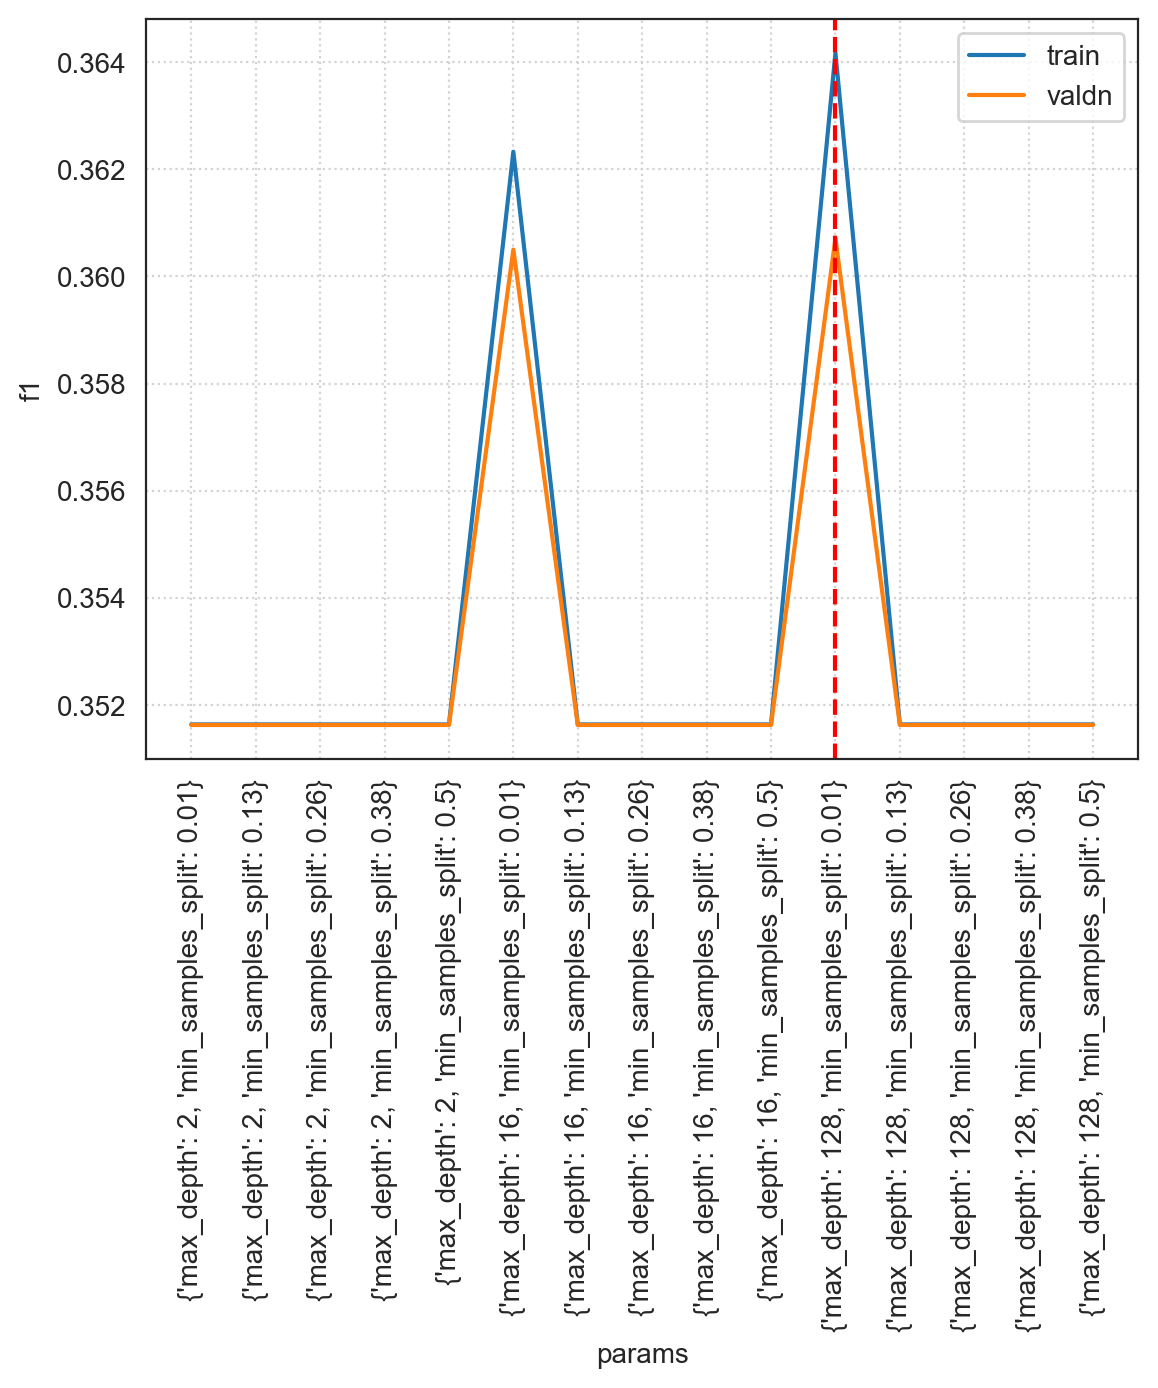

In [33]:
# Model 1
# Using scaled training dataset

params = {
    'max_depth': np.logspace(1,7,3,base=2).astype(int),
    'min_samples_split': np.linspace(.01,.5,5).round(2),
}
gs_dt1 = GridSearchCV(
    DecisionTreeClassifier(random_state=random_state),
    params, **grid_search_defaults
)
gs_dt1.fit(
    X_train,
    y_train
)
plot_grid_search_results(gs_dt1, 'f1')

C:\Users\Srikanth\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Srikanth\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


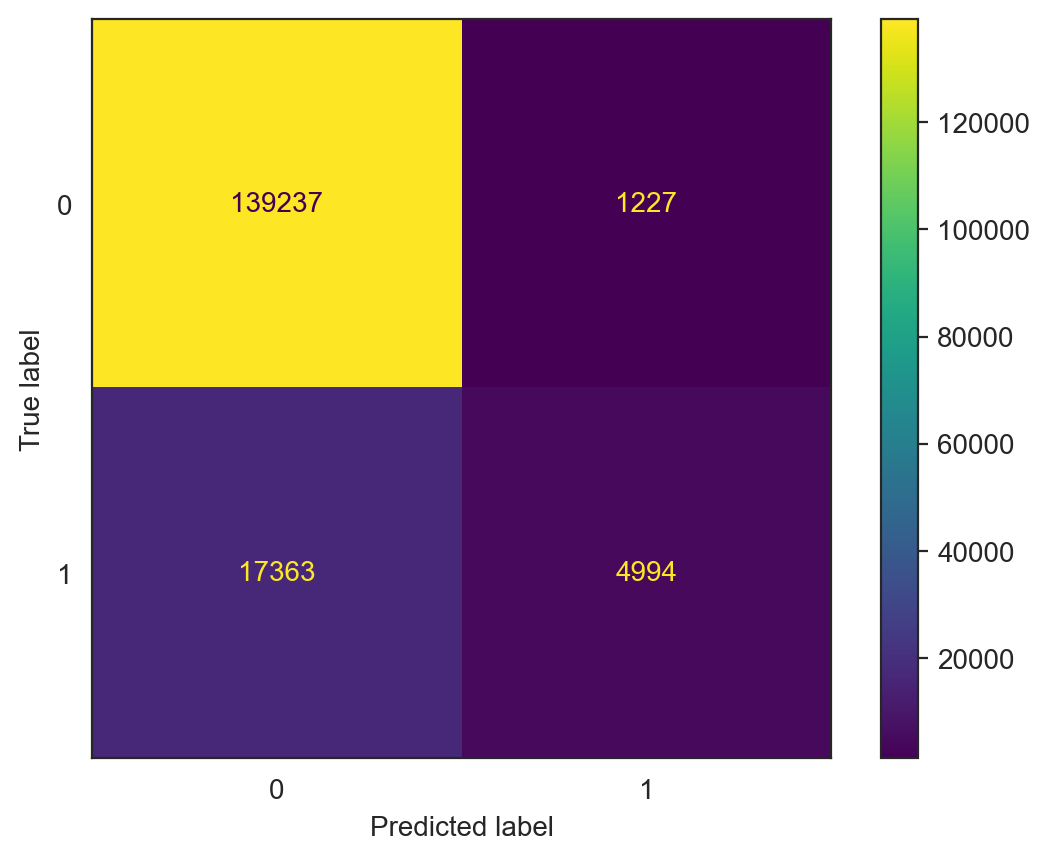

Accuracy score: 0.89
F1 score: 0.35
Recall score: 0.22
Precision score: 0.80
Balanced accuracy score: 0.61
ROC AUC score: 0.78


In [34]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def score_classification_model(fitted_model, X, y_true):
    # Predicting classes
    predictions = fitted_model.predict(X)

    # Predicting probabilities for ROC AUC calculation; assume positive class is at index 1
    probabilities = fitted_model.predict_proba(X)[:, 1]

    # Confusion Matrix
    cm = confusion_matrix(y_true, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fitted_model.classes_)
    disp.plot()
    plt.show()

    # Print other metrics
    print(f"Accuracy score: {accuracy_score(y_true, predictions):.2f}")
    print(f"F1 score: {f1_score(y_true, predictions):.2f}")
    print(f"Recall score: {recall_score(y_true, predictions):.2f}")
    print(f"Precision score: {precision_score(y_true, predictions):.2f}")
    print(f"Balanced accuracy score: {balanced_accuracy_score(y_true, predictions):.2f}")
    print(f"ROC AUC score: {roc_auc_score(y_true, probabilities):.2f}")

# Example call to the function
score_classification_model(gs_dt1, X_test_mms, y_test)


In [35]:
print(f"Length of X_test_mms: {len(X_test_mms)}")
print(f"Length of y_test: {len(y_test)}")


Length of X_test_mms: 162821
Length of y_test: 162821


C:\Users\Srikanth\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


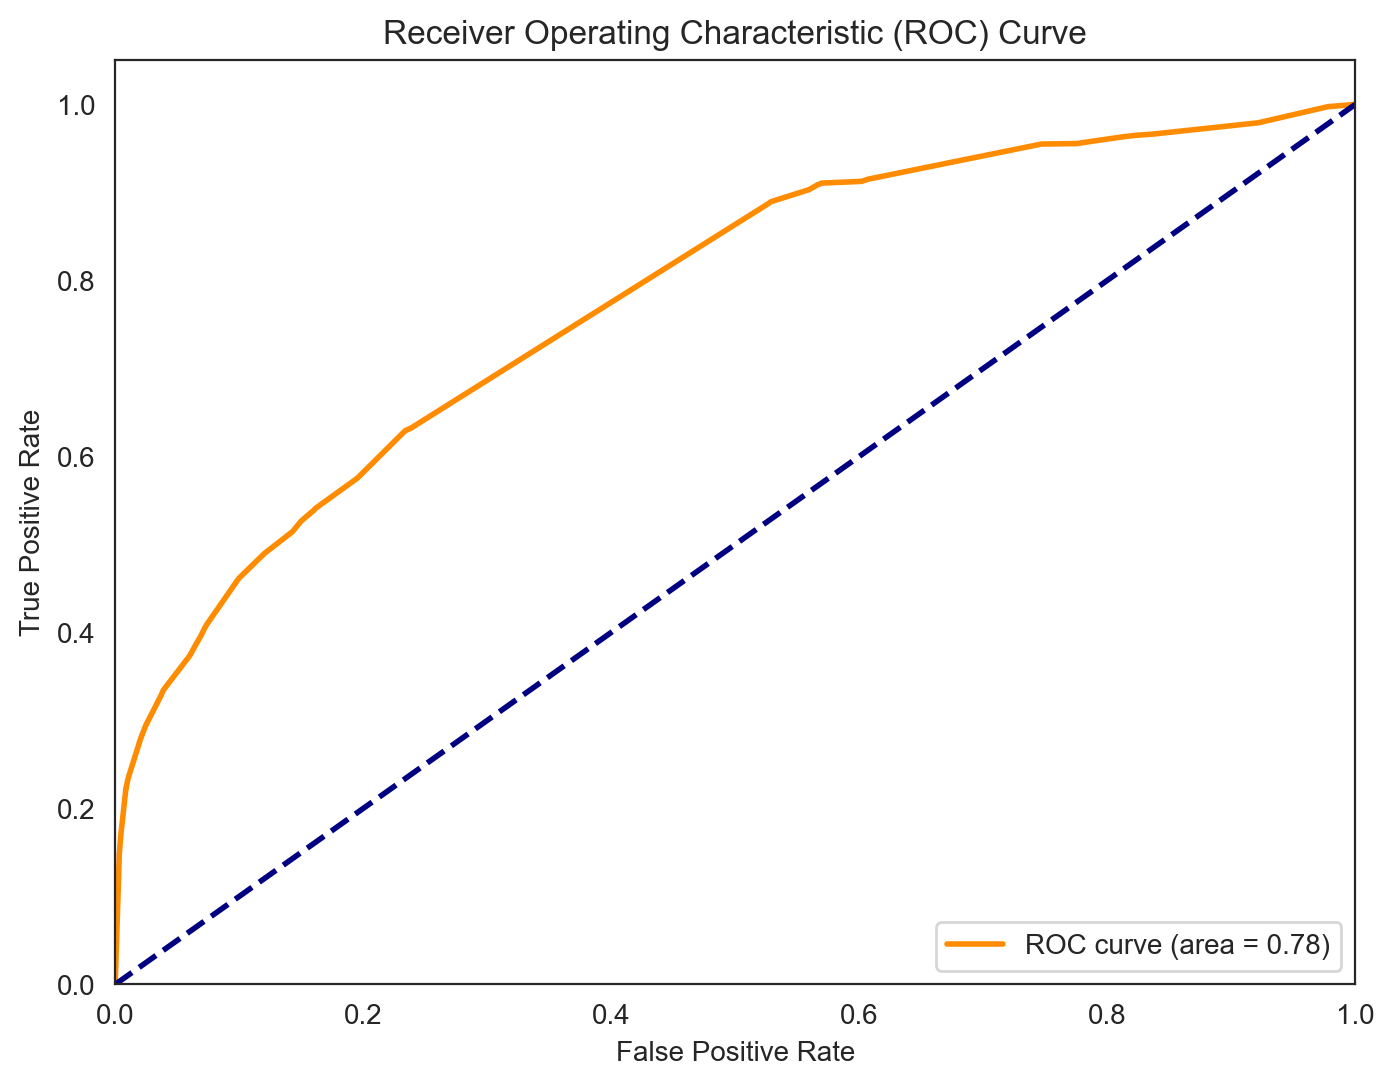

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(fitted_model, X_test, y_test):
    # Predicting probabilities
    probabilities = fitted_model.predict_proba(X_test)[:, 1]  # Assuming positive class is at index 1

    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, probabilities)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Example call to the function with your model and test data
plot_roc_curve(gs_dt1, X_test_mms, y_test)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Estimator:
DecisionTreeClassifier(class_weight='balanced', max_depth=16,
                       min_samples_split=0.01, random_state=2021)

Best Result (Suggested):
	                      train  valdn
	                  f1   0.43   0.42
	              recall   0.69   0.69
	           precision   0.31   0.31
	   balanced_accuracy   0.72   0.72
	            accuracy   0.74   0.74
	             roc_auc   0.81   0.81

Params:
	{'max_depth': 16, 'min_samples_split': 0.01}



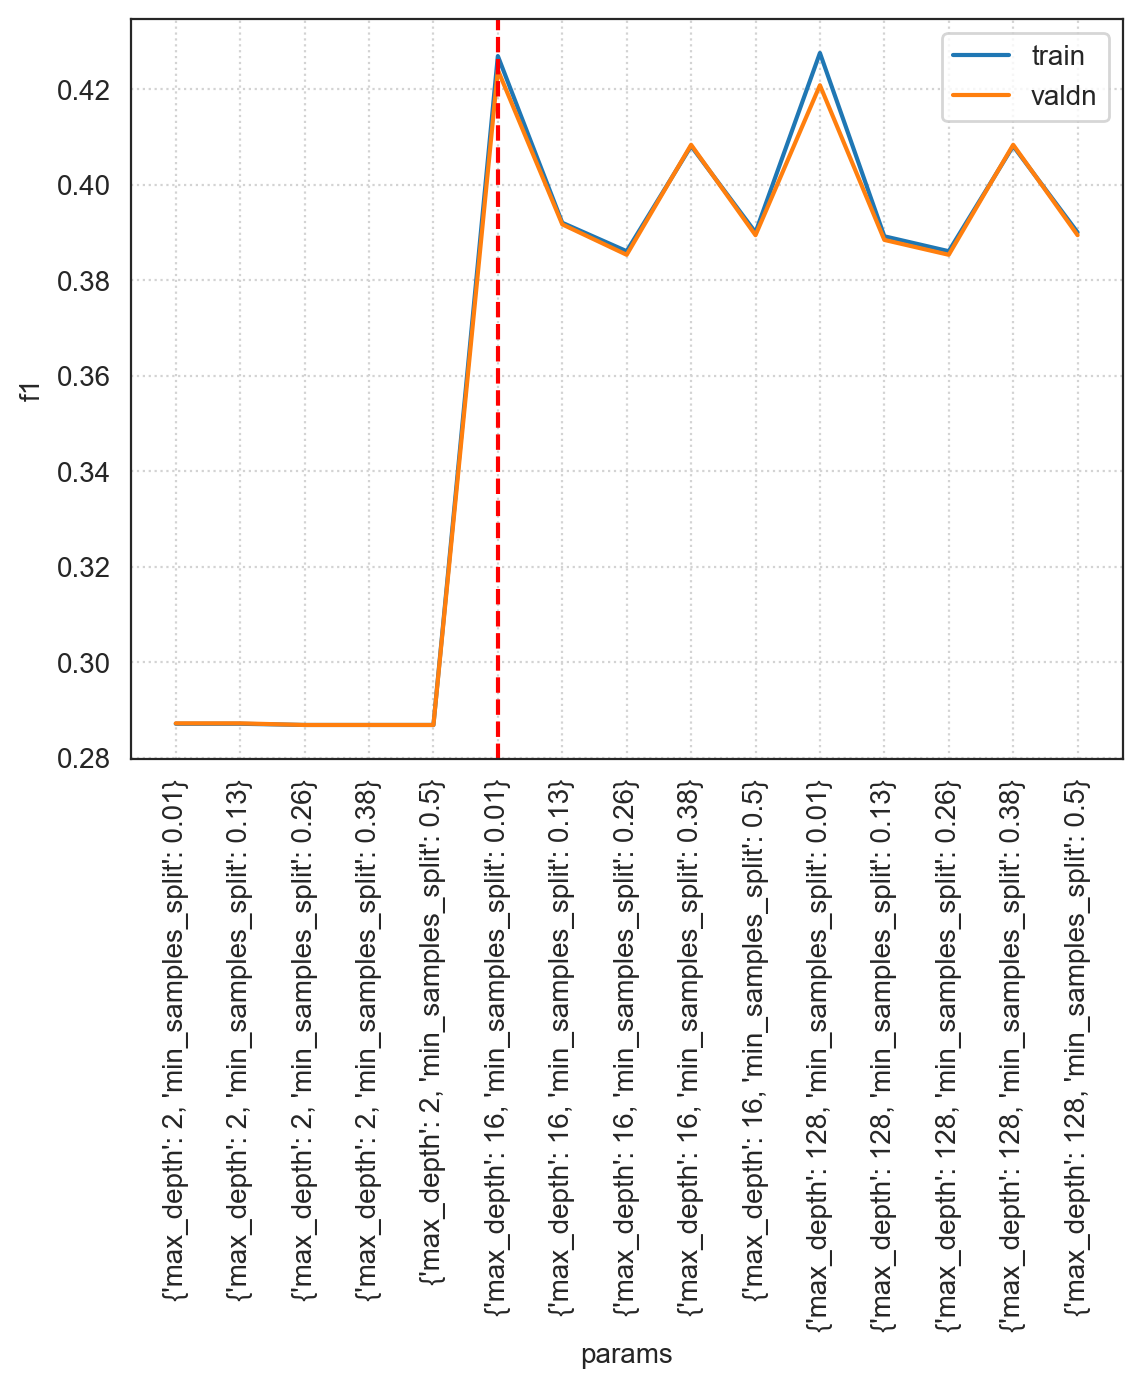

In [37]:
# Model 2
# Using scaled training dataset, balanced class weight


params = {
    'max_depth': np.logspace(1,7,3,base=2).astype(int),
    'min_samples_split': np.linspace(.01,.5,5).round(2),
}

gs_dt2 = GridSearchCV(
    DecisionTreeClassifier(random_state=random_state, class_weight='balanced'),
    params, **grid_search_defaults
)
gs_dt2.fit(
    X_train_mms,
    y_train
)
plot_grid_search_results(gs_dt2, 'f1')

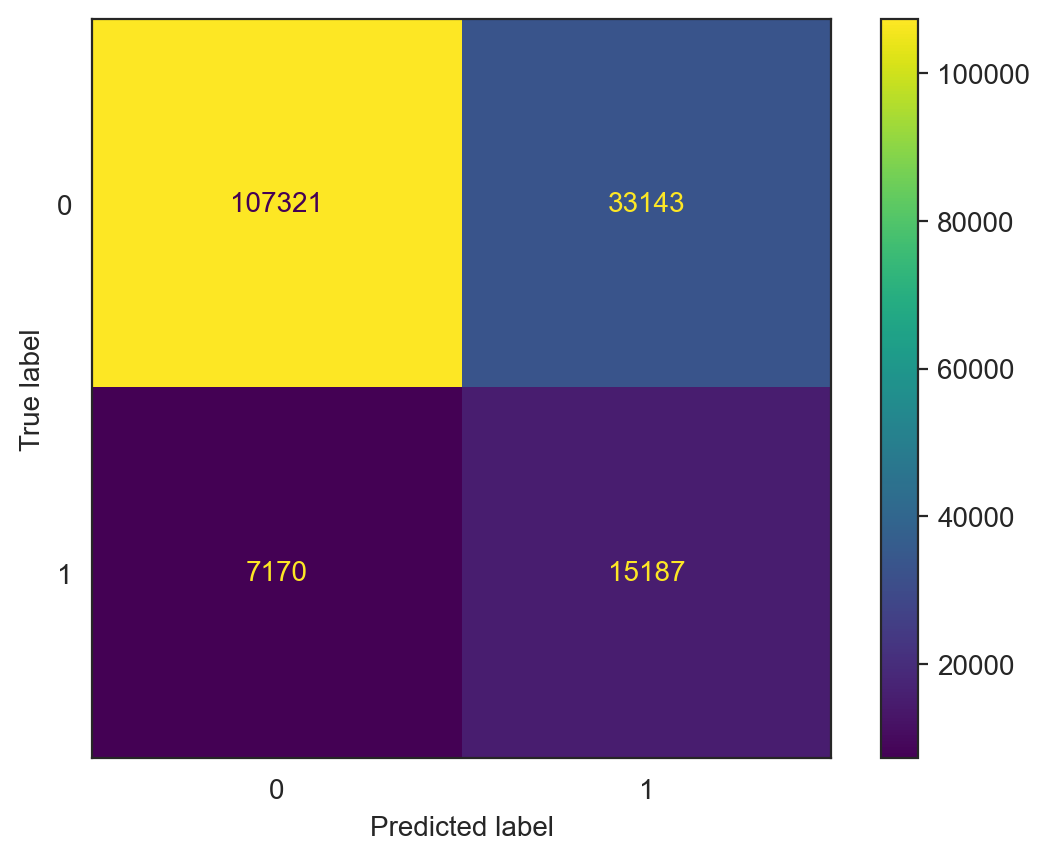

Accuracy score: 0.75
F1 score: 0.43
Recall score: 0.68
Precision score: 0.31
Balanced accuracy score: 0.72
ROC AUC score: 0.81


In [38]:
score_classification_model(gs_dt2, X_test_mms, y_test)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Estimator:
DecisionTreeClassifier(max_depth=128, min_samples_split=0.01, random_state=2021)

Best Result (Suggested):
	                      train  valdn
	                  f1   0.73   0.73
	              recall   0.73   0.73
	           precision   0.73   0.73
	   balanced_accuracy   0.73   0.73
	            accuracy   0.73   0.73
	             roc_auc   0.82   0.81

Params:
	{'max_depth': 128, 'min_samples_split': 0.01}



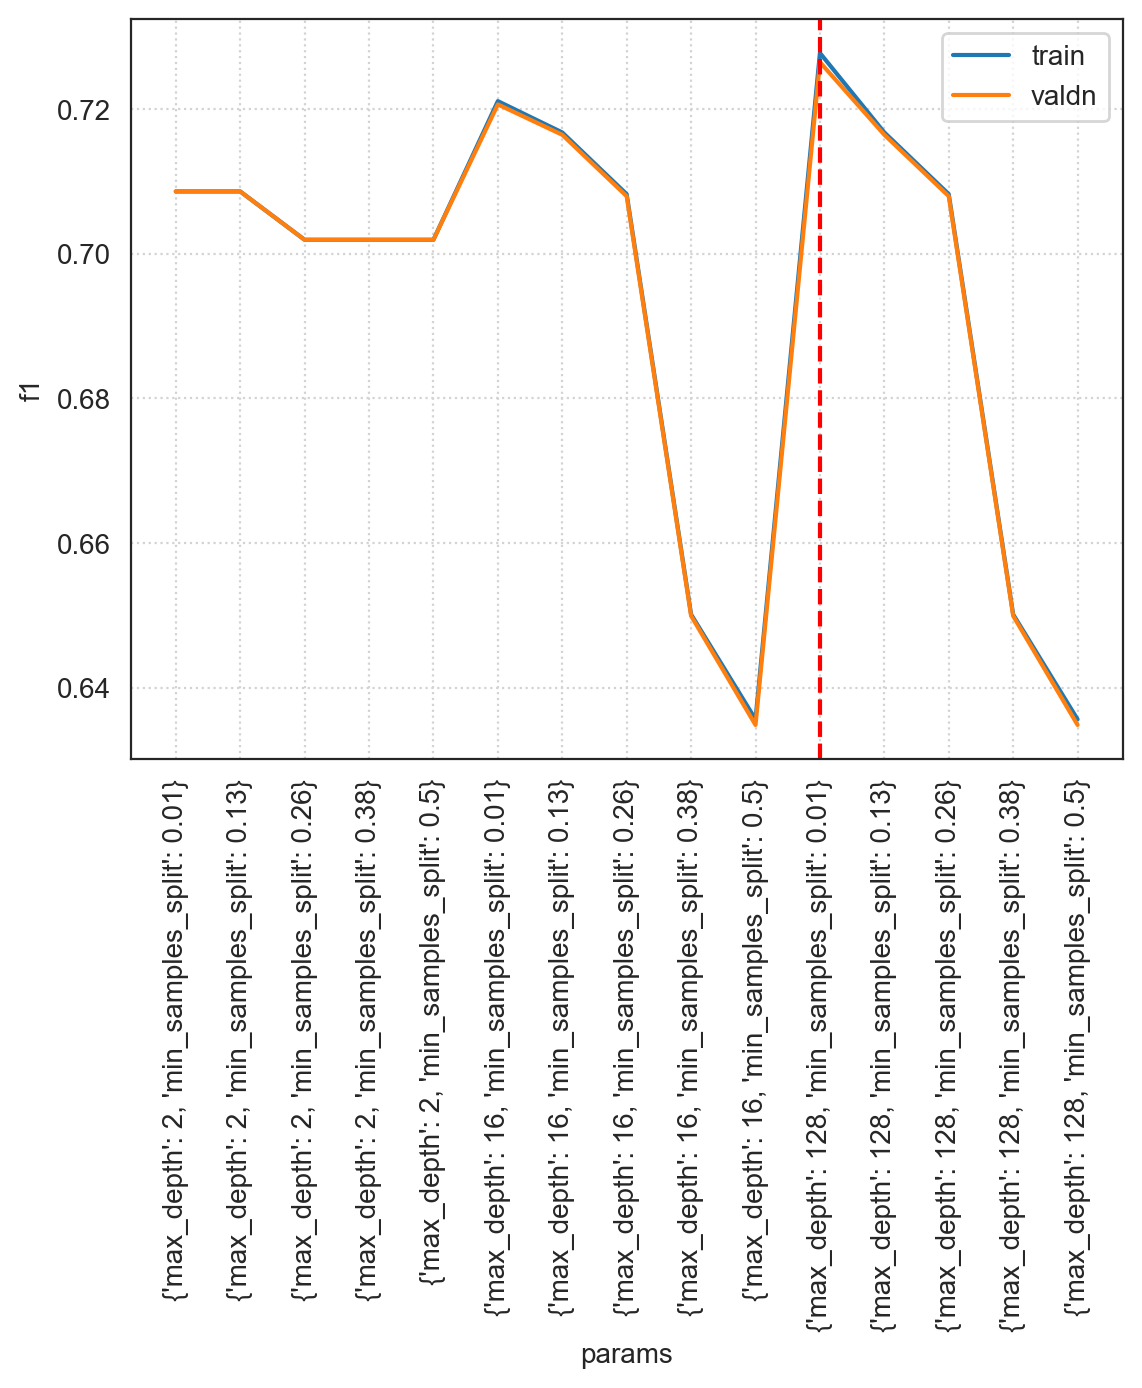

In [39]:
# Model 3
# Using scaled Re-sampled training dataset

params = {
    'max_depth': np.logspace(1,7,3,base=2).astype(int),
    'min_samples_split': np.linspace(.01,.5,5).round(2),
}

gs_dt3 = GridSearchCV(
    DecisionTreeClassifier(random_state=random_state),
    params, **grid_search_defaults
)
gs_dt3.fit(
    X_train_resampled_mms,
    y_train_resampled
)
plot_grid_search_results(gs_dt3, 'f1')

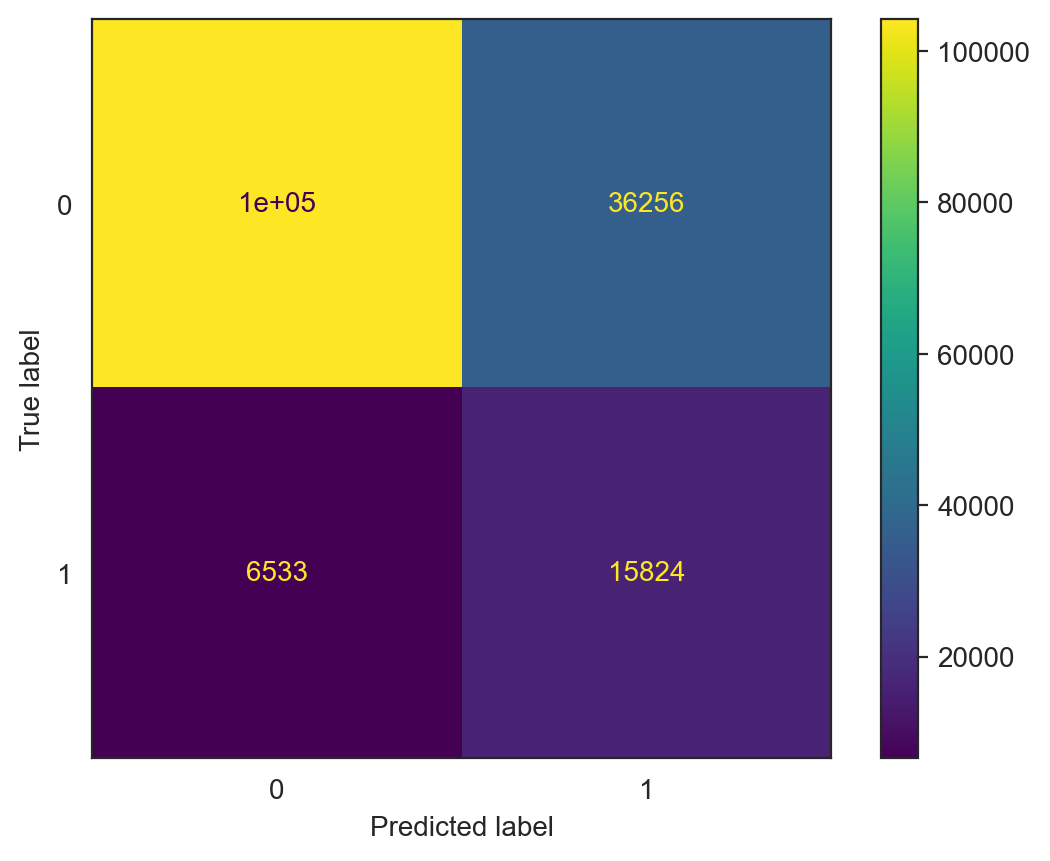

Accuracy score: 0.74
F1 score: 0.43
Recall score: 0.71
Precision score: 0.30
Balanced accuracy score: 0.72
ROC AUC score: 0.81


In [40]:
score_classification_model(gs_dt3, X_test_mms, y_test)

# Plot tree to understand feature importance

If the trees doesn't show up in the notebook, check the html export

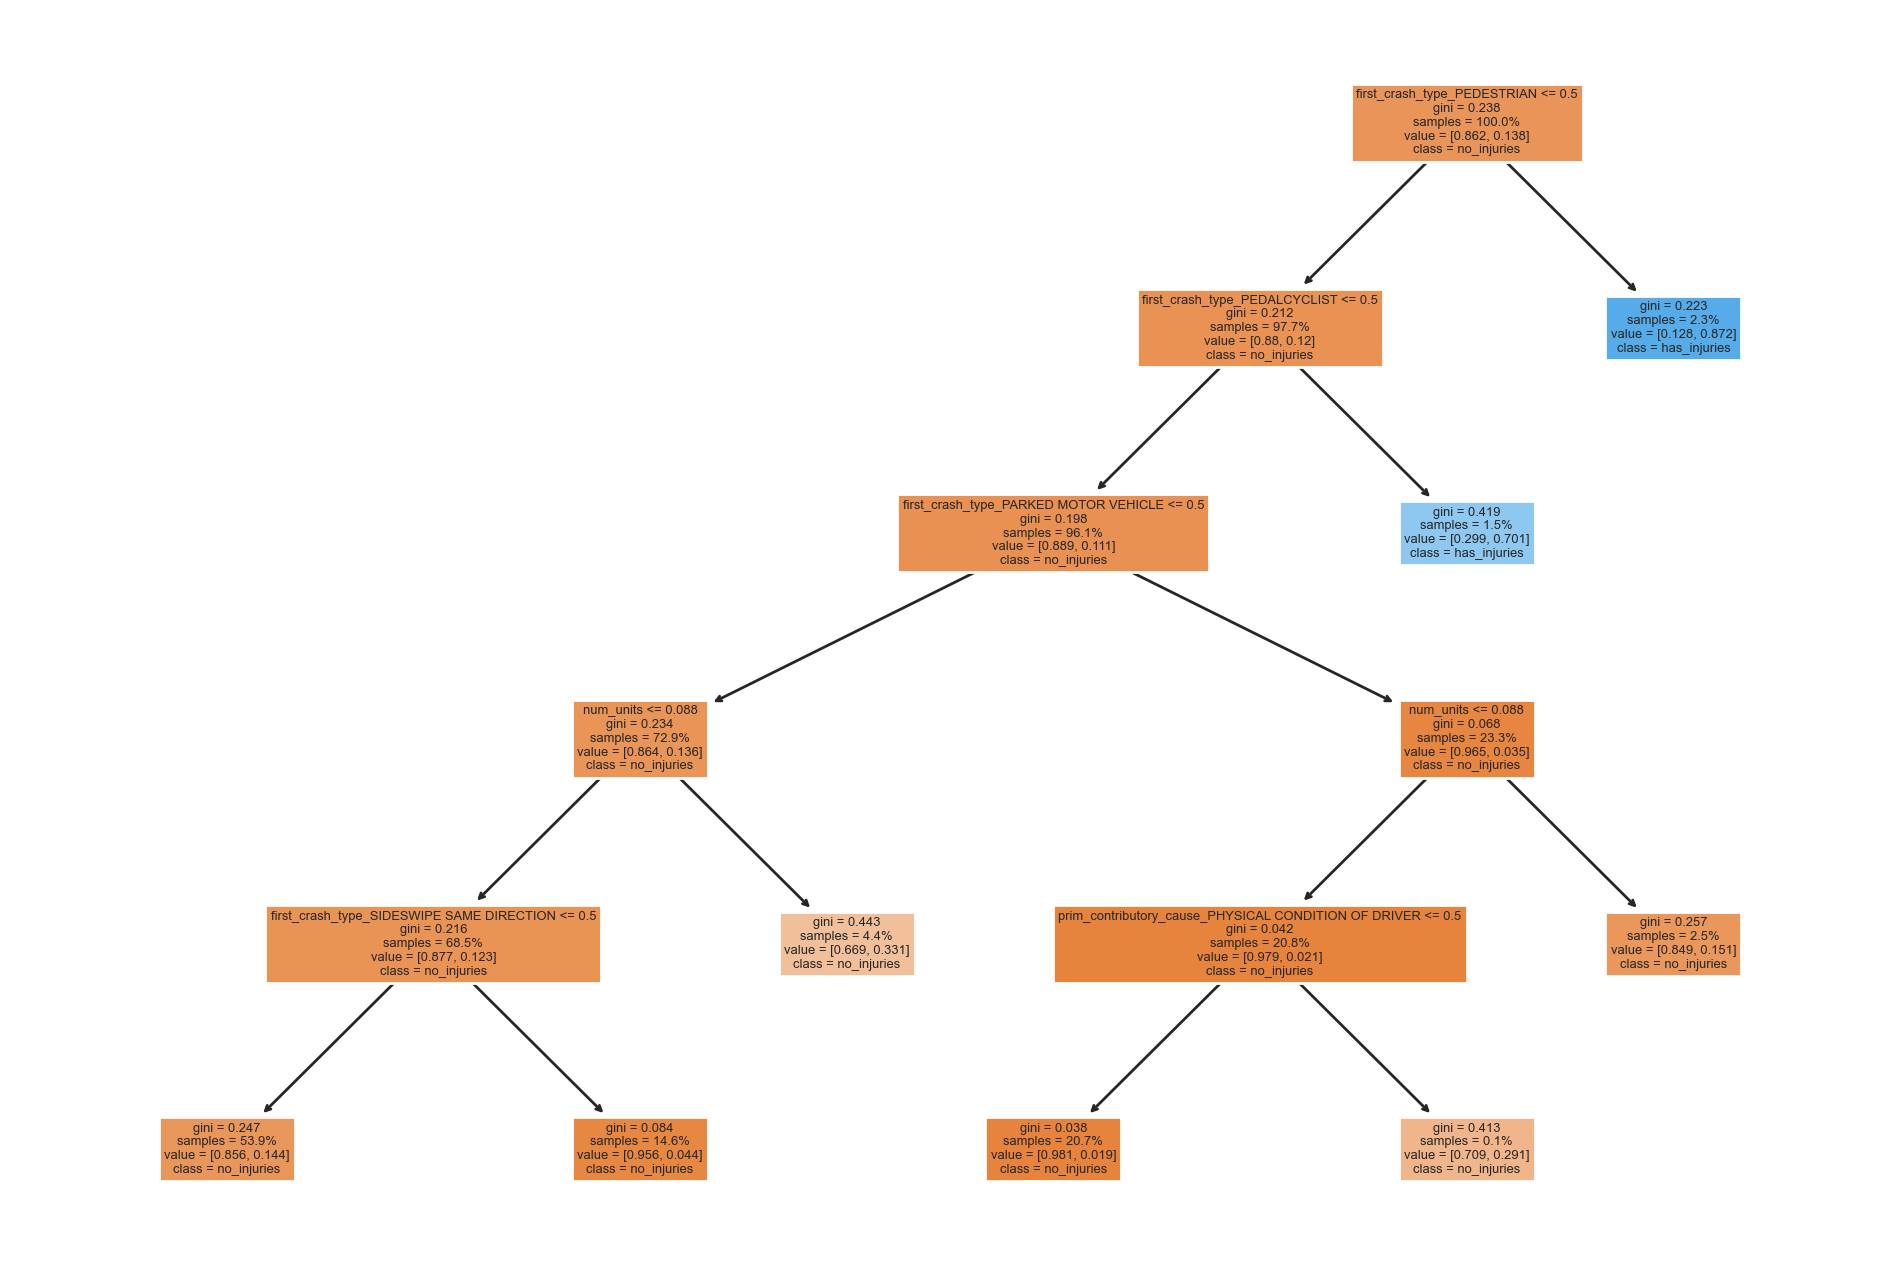

In [41]:
# Original Training Dataset (Not-Oversampled)
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
params = {
    'max_depth': 5,
    'min_samples_split': .1,
#    'class_weight': 'balanced',
}
clf = DecisionTreeClassifier(**params)
clf.fit(X_train_mms, y_train)

fn = X_train.columns.values
cn = ['no_injuries','has_injuries']


# Define your classifier
clf = DecisionTreeClassifier(**params)

# Fit the classifier to your data
clf.fit(X_train_mms, y_train)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X_train.columns, class_names=cn, filled=True, proportion=True)
plt.show()


In [42]:
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train_mms.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 115 (0.554738)
2. feature 114 (0.222304)
3. feature 4 (0.092587)
4. feature 113 (0.076163)
5. feature 121 (0.049582)
6. feature 154 (0.004627)
7. feature 203 (0.000000)
8. feature 72 (0.000000)
9. feature 71 (0.000000)
10. feature 70 (0.000000)
11. feature 69 (0.000000)
12. feature 68 (0.000000)
13. feature 67 (0.000000)
14. feature 66 (0.000000)
15. feature 65 (0.000000)
16. feature 64 (0.000000)
17. feature 63 (0.000000)
18. feature 74 (0.000000)
19. feature 62 (0.000000)
20. feature 61 (0.000000)
21. feature 60 (0.000000)
22. feature 59 (0.000000)
23. feature 58 (0.000000)
24. feature 57 (0.000000)
25. feature 56 (0.000000)
26. feature 55 (0.000000)
27. feature 54 (0.000000)
28. feature 53 (0.000000)
29. feature 73 (0.000000)
30. feature 77 (0.000000)
31. feature 75 (0.000000)
32. feature 87 (0.000000)
33. feature 96 (0.000000)
34. feature 95 (0.000000)
35. feature 94 (0.000000)
36. feature 93 (0.000000)
37. feature 92 (0.000000)
38. feature 91 (0.000000)

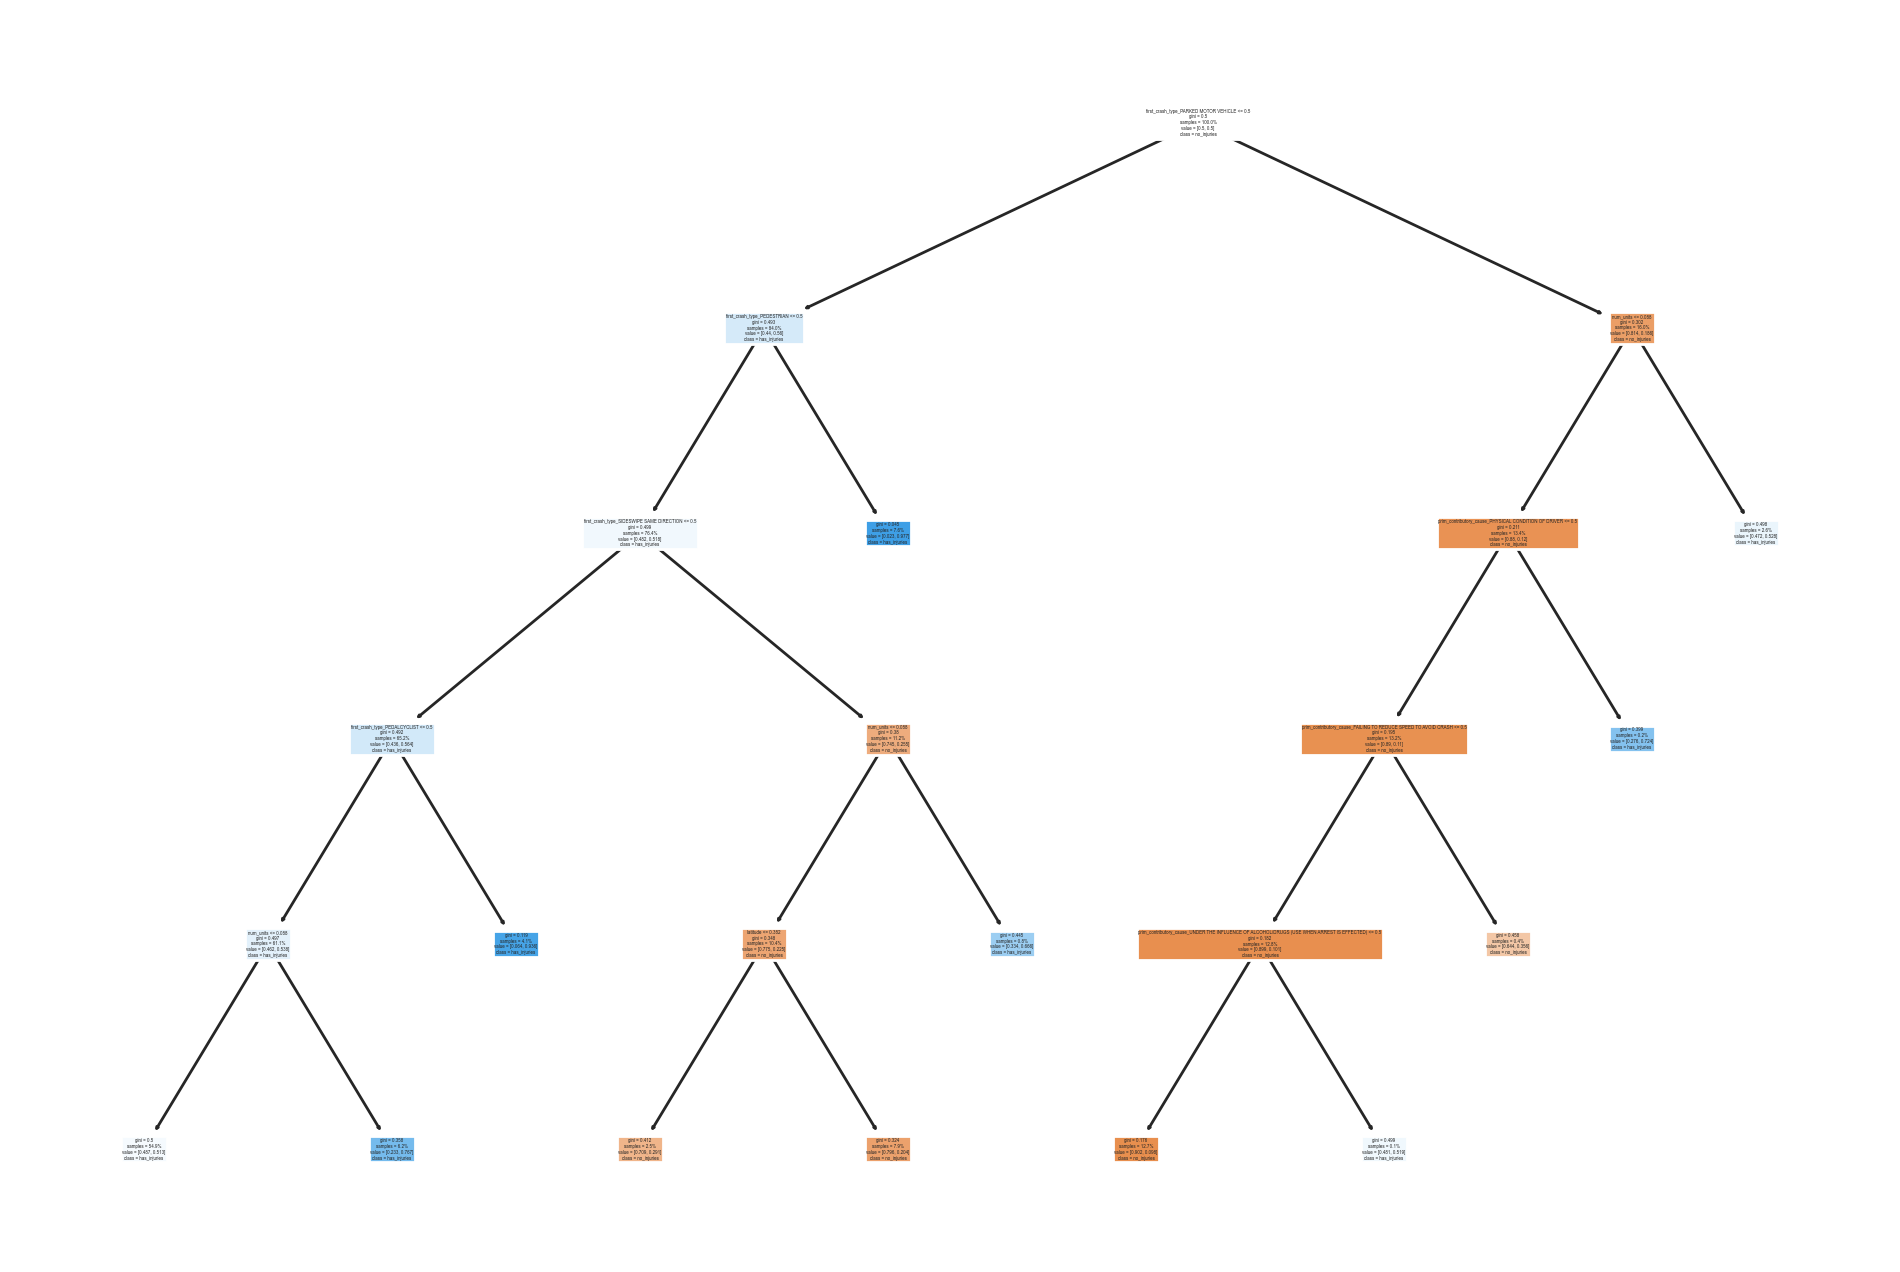

In [43]:
# Resampled Training Dataset (Oversampled)

params = {
    'max_depth': 5,
    'min_samples_split': .1
}
clf = DecisionTreeClassifier(**params)
clf.fit(X_train_resampled_mms, y_train_resampled)

fn = X_train.columns.values
cn = ['no_injuries','has_injuries']
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X_train.columns, class_names=cn, filled=True, proportion=True)
plt.show()
